# Deep Dive into Diffusion Models: From DDPM to Stable Diffusion (CelebA Demo)

This notebook provides a theoretical overview of Denoising Diffusion Probabilistic Models (DDPMs), Latent Diffusion Models (LDMs), and Stable Diffusion. It concludes with a practical coding demonstration of training a basic Latent Diffusion Model on the higher-resolution CelebA dataset.

## Part 1: Theoretical Foundations

### 1.1 Denoising Diffusion Probabilistic Models (DDPMs)

Denoising Diffusion Probabilistic Models (DDPMs) are a class of generative models inspired by non-equilibrium thermodynamics. They learn to reverse a gradual noising process to generate data from noise.

#### The Forward (Diffusion) Process
The forward process gradually adds Gaussian noise to an image $\mathbf{x}_0$ over $T$ timesteps, creating a sequence of noisy samples $\mathbf{x}_1, \dots, \mathbf{x}_T$. This process is fixed and can be described as a Markov chain:
$$q(\mathbf{x}_t | \mathbf{x}_{t-1}) = \mathcal{N}(\mathbf{x}_t; \sqrt{1 - \beta_t} \mathbf{x}_{t-1}, \beta_t \mathbf{I})$$
where $\beta_t$ are small positive constants known as variance schedule. A remarkable property is that $\mathbf{x}_t$ can be directly sampled from $\mathbf{x}_0$ at any timestep $t$:
$$q(\mathbf{x}_t | \mathbf{x}_0) = \mathcal{N}(\mathbf{x}_t; \sqrt{\bar{\alpha}_t} \mathbf{x}_0, (1 - \bar{\alpha}_t) \mathbf{I})$$
where $\alpha_t = 1 - \beta_t$ and $\bar{\alpha}_t = \prod_{s=1}^t \alpha_s$. This means $\mathbf{x}_t = \sqrt{\bar{\alpha}_t} \mathbf{x}_0 + \sqrt{1 - \bar{\alpha}_t} \mathbf{\epsilon}$, where $\mathbf{\epsilon} \sim \mathcal{N}(0, \mathbf{I})$.

#### The Reverse (Denoising) Process
The reverse process aims to recover $\mathbf{x}_{t-1}$ from $\mathbf{x}_t$. Since $q(\mathbf{x}_{t-1} | \mathbf{x}_t)$ is intractable, we learn a neural network $p_\theta(\mathbf{x}_{t-1} | \mathbf{x}_t)$ to approximate it. The goal is to start with pure noise $\mathbf{x}_T \sim \mathcal{N}(0, \mathbf{I})$ and iteratively denoise it to obtain a clean image $\mathbf{x}_0$.

The reverse step is approximated as:
$$p_\theta(\mathbf{x}_{t-1} | \mathbf{x}_t) = \mathcal{N}(\mathbf{x}_{t-1}; \mathbf{\mu}_\theta(\mathbf{x}_t, t), \mathbf{\Sigma}_\theta(\mathbf{x}_t, t))$$
It can be shown that if the neural network predicts the noise $\mathbf{\epsilon}_\theta(\mathbf{x}_t, t)$ that was added at timestep $t$, the mean $\mathbf{\mu}_\theta$ can be derived:
$$\mathbf{\mu}_\theta(\mathbf{x}_t, t) = \frac{1}{\sqrt{\alpha_t}} \left( \mathbf{x}_t - \frac{\beta_t}{\sqrt{1 - \bar{\alpha}_t}} \mathbf{\epsilon}_\theta(\mathbf{x}_t, t) \right)$$
The variance $\mathbf{\Sigma}_\theta$ is often set to a fixed value, such as $\beta_t \mathbf{I}$ or a function of $\beta_t$ and $\bar{\beta}_t$.

![img](https://lilianweng.github.io/posts/2021-07-11-diffusion-models/DDPM.png)

#### Training Objective
The model is trained to predict the noise $\mathbf{\epsilon}$ that was added to $\mathbf{x}_0$ to obtain $\mathbf{x}_t$. The simplified objective function is a mean squared error (MSE) loss:
$$\mathcal{L} = \mathbb{E}_{t \sim [1, T], \mathbf{x}_0 \sim q(\mathbf{x}_0), \mathbf{\epsilon} \sim \mathcal{N}(0, \mathbf{I})} \left[ \| \mathbf{\epsilon} - \mathbf{\epsilon}_\theta(\sqrt{\bar{\alpha}_t} \mathbf{x}_0 + \sqrt{1 - \bar{\alpha}_t} \mathbf{\epsilon}, t) \|^2 \right]$$
A U-Net architecture is commonly used as the noise prediction network $\mathbf{\epsilon}_\theta$, with the timestep $t$ typically incorporated via sinusoidal positional embeddings.

### 1.2 Latent Diffusion Models (LDMs)
<p align="center">
    <img src="https://cdn-images-1.medium.com/max/800/1*7W6GB7yZGWO7bpWlSpNGcQ.png" alt="LDM Overview" width="700"/>
</p>
<p align="center">
    <em>Figure: Overview of the Latent Diffusion Model (LDM) pipeline. Source: <a href="https://arxiv.org/abs/2112.10752">Rombach et al., 2022</a></em>
</p>
Latent Diffusion Models (LDMs), also known as Stable Diffusion, address a key limitation of vanilla DDPMs: their computational expense. DDPMs operate directly on high-resolution pixel space, which requires significant computational resources and time.

LDMs introduce an **autoencoder** to transform images into a lower-dimensional **latent space**. The diffusion process (both forward and reverse) then operates entirely within this more compact latent representation.

#### Components of an LDM
1.  **Perceptual Compression (Encoder/Decoder)**: An autoencoder is trained to encode images $\mathbf{x}$ into a latent representation $\mathbf{z}$ (encoder: $\mathcal{E}$) and decode latents back into pixel space (decoder: $\mathcal{D}$). This compression aims to retain perceptual quality while reducing dimensionality. $z = \mathcal{E}(x)$ and $x = \mathcal{D}(z)$.
2.  **Latent Diffusion Model**: This is the core diffusion model (e.g., a U-Net) that operates on the latent space $\mathbf{z}$. It is trained to predict noise in the latent space, just like a DDPM predicts noise in pixel space. The training objective is similar:
    $$\mathcal{L}_{LDM} = \mathbb{E}_{t, \mathbf{z}_0, \mathbf{\epsilon}} \left[ \| \mathbf{\epsilon} - \mathbf{\epsilon}_\theta(\sqrt{\bar{\alpha}_t} \mathbf{z}_0 + \sqrt{1 - \bar{\alpha}_t} \mathbf{\epsilon}, t) \|^2 \right]$$
    where $\mathbf{z}_0 = \mathcal{E}(\mathbf{x}_0)$.
3.  **Cross-Attention (Optional but common)**: For conditional generation (e.g., text-to-image), LDMs incorporate a cross-attention mechanism into the U-Net. This allows the model to condition the diffusion process on external information, such as text embeddings from a large language model (e.g., CLIP's text encoder). The U-Net then takes an additional conditioning input $c$.

#### Advantages of LDMs
* **Reduced Computational Cost**: Operating in a lower-dimensional latent space drastically reduces memory and computational requirements, enabling training on higher-resolution images and faster inference.
* **Efficient Generation**: The synthesis process is significantly faster because the iterative denoising steps are performed on smaller latents.
* **Conditional Generation**: The architecture readily integrates conditioning mechanisms, making it suitable for tasks like text-to-image generation.

### 1.3 Stable Diffusion Models

Stable Diffusion is a specific, highly successful implementation of a Latent Diffusion Model. It was released by Stability AI and is widely used for text-to-image generation, image-to-image translation, inpainting, outpainting, and more.

Key aspects of Stable Diffusion that make it powerful:

1.  **Pre-trained Variational Autoencoder (VAE)**: Stable Diffusion uses a pre-trained VAE for the perceptual compression step. This VAE is trained on a massive dataset to learn a high-quality, perceptually relevant latent space.
2.  **U-Net with Cross-Attention**: The diffusion model is a U-Net that operates in the VAE's latent space. Crucially, it integrates cross-attention layers. These layers allow the U-Net to be conditioned on various inputs, most notably text prompts.
3.  **Text Encoder (CLIP)**: For text-to-image generation, Stable Diffusion uses a frozen pre-trained text encoder (often the text encoder from OpenAI's CLIP model) to transform text prompts into a rich embedding space. These text embeddings serve as the conditioning input for the U-Net's cross-attention layers.
4.  **Extensive Training Data**: Stable Diffusion was trained on incredibly large and diverse datasets (e.g., LAION-5B), which contributes to its remarkable generalization capabilities and ability to generate a wide variety of images based on diverse prompts.
5.  **Sampling Algorithms**: While DDPMs primarily use deterministic sampling (DDIM), Stable Diffusion, like other LDMs, supports various sampling algorithms (e.g., DDIM, PLMS, DPM-Solver, Euler A) that allow for faster generation with fewer steps while maintaining quality.

The overall workflow for text-to-image generation with Stable Diffusion is:
1.  A text prompt is encoded into a text embedding using the CLIP text encoder.
2.  Random noise is generated in the VAE's latent space.
3.  The U-Net iteratively denoises this latent noise, guided by the text embedding via cross-attention.
4.  Once the latent noise is fully denoised into a clean latent representation, the VAE decoder transforms it back into a high-resolution pixel image.

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

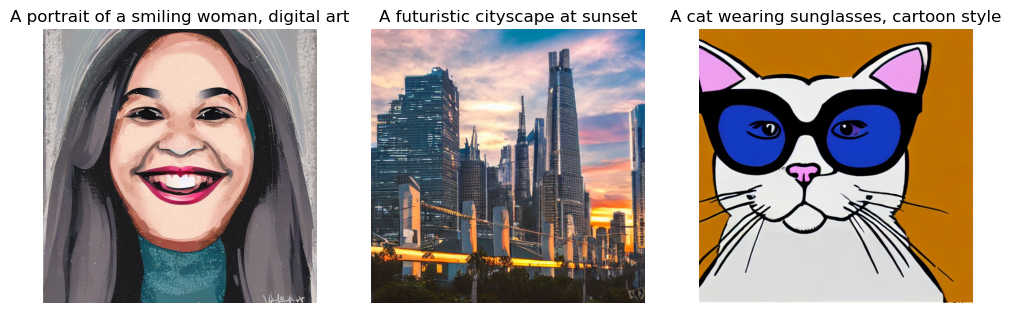

In [3]:
from diffusers import StableDiffusionPipeline
import torch

import matplotlib.pyplot as plt
device = "cuda" 
# Load Stable Diffusion from HuggingFace (requires internet and ~4GB VRAM)
pipe = StableDiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5").to(device)

prompts = [
    "A portrait of a smiling woman, digital art",
    "A futuristic cityscape at sunset",
    "A cat wearing sunglasses, cartoon style"
]

images = []
for prompt in prompts:
    with torch.no_grad():
        image = pipe(prompt, guidance_scale=7.5).images[0]
        images.append(image)

# Display the generated images
plt.figure(figsize=(12, 4))
for i, img in enumerate(images):
    plt.subplot(1, len(images), i+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(prompts[i])
plt.show()

## Part 2: Coding Demo - Training a Latent Diffusion Model on CelebA

This section provides a simplified implementation of a Latent Diffusion Model. We will use the CelebA dataset, which features human faces, and train a VAE and then a diffusion model in its latent space. Note that training a full-fledged LDM like Stable Diffusion requires significant computational resources and much longer training times.

### 2.1 Imports and Setup

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import math
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from math import sqrt, log

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


### 2.2 Data Preparation (CelebA)

In [4]:
img_size = 256 # Using a higher resolution for CelebA
batch_size = 64 # Reduced batch size to manage memory for higher resolution

transform = transforms.Compose([
    transforms.CenterCrop(178), # CelebA images are 178x218, center crop to square
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Normalize to [-1, 1] for 3 channels
])

# Use split='train' to download and load the training set
train_dataset = datasets.CelebA(root='./data', split='train', download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

print(f"Number of training samples: {len(train_dataset)}")

Files already downloaded and verified
Number of training samples: 162770


### 2.3 Variational Autoencoder (VAE) for Latent Space

We'll define a simple VAE that outputs a spatial latent representation suitable for a 2D U-Net. This VAE will be trained to compress the 64x64 CelebA images into a smaller spatial latent representation.


Training Spatial VAE...


VAE Epoch 1/10: 100%|██████████| 2544/2544 [01:41<00:00, 25.12it/s]


Spatial VAE Epoch 1/10, Loss: 5038.7848


VAE Epoch 2/10: 100%|██████████| 2544/2544 [01:34<00:00, 27.02it/s]


Spatial VAE Epoch 2/10, Loss: 2189.8174


VAE Epoch 3/10: 100%|██████████| 2544/2544 [01:41<00:00, 25.02it/s]


Spatial VAE Epoch 3/10, Loss: 1993.1080


VAE Epoch 4/10: 100%|██████████| 2544/2544 [01:40<00:00, 25.29it/s]


Spatial VAE Epoch 4/10, Loss: 1786.1583


VAE Epoch 5/10: 100%|██████████| 2544/2544 [01:41<00:00, 25.17it/s]


Spatial VAE Epoch 5/10, Loss: 1714.2019


VAE Epoch 6/10: 100%|██████████| 2544/2544 [01:33<00:00, 27.13it/s]


Spatial VAE Epoch 6/10, Loss: 1666.9569


VAE Epoch 7/10: 100%|██████████| 2544/2544 [01:41<00:00, 24.95it/s]


Spatial VAE Epoch 7/10, Loss: 1631.0246


VAE Epoch 8/10: 100%|██████████| 2544/2544 [01:40<00:00, 25.21it/s]


Spatial VAE Epoch 8/10, Loss: 1602.5302


VAE Epoch 9/10: 100%|██████████| 2544/2544 [01:34<00:00, 26.96it/s]


Spatial VAE Epoch 9/10, Loss: 1578.8041


VAE Epoch 10/10: 100%|██████████| 2544/2544 [01:42<00:00, 24.90it/s]

Spatial VAE Epoch 10/10, Loss: 1559.3034


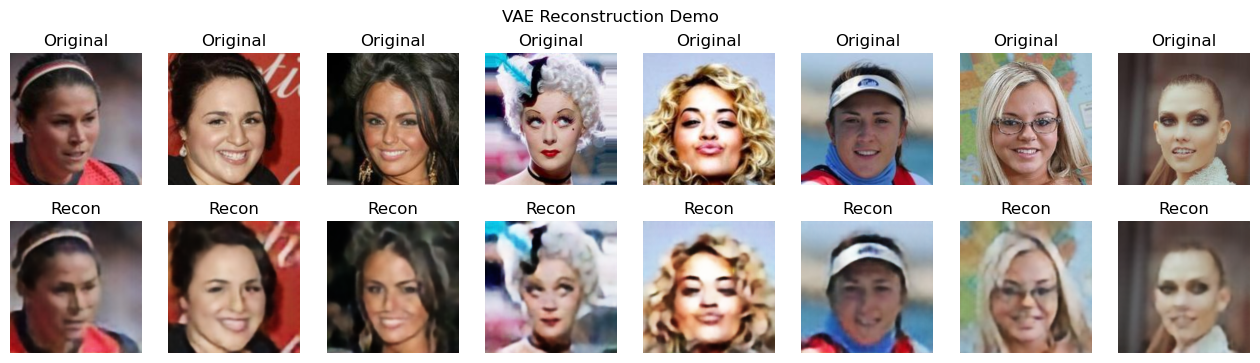

In [5]:
class VAE_Encoder_Spatial(nn.Module):
    def __init__(self, img_channels=3, base_channels=32, latent_channels=4):
        super().__init__()
        # Input 64x64
        self.conv1 = nn.Conv2d(img_channels, base_channels, 4, 2, 1) # 64 -> 32
        self.conv2 = nn.Conv2d(base_channels, base_channels * 2, 4, 2, 1) # 32 -> 16
        self.conv3 = nn.Conv2d(base_channels * 2, base_channels * 4, 4, 2, 1) # 16 -> 8
        self.conv4 = nn.Conv2d(base_channels * 4, base_channels * 8, 4, 2, 1) # 8 -> 4
        # Output is (batch_size, base_channels*8, 4, 4)
        self.final_conv = nn.Conv2d(base_channels * 8, latent_channels, 1) # Reduce channels to latent_channels

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        z = self.final_conv(x) # latent shape (batch, latent_channels, 4, 4)
        return z

class VAE_Decoder_Spatial(nn.Module):
    def __init__(self, img_channels=3, base_channels=32, latent_channels=4):
        super().__init__()
        self.initial_conv = nn.Conv2d(latent_channels, base_channels * 8, 1) # From latent channels 4 to 256
        self.deconv1 = nn.ConvTranspose2d(base_channels * 8, base_channels * 4, 4, 2, 1) # 4 -> 8
        self.deconv2 = nn.ConvTranspose2d(base_channels * 4, base_channels * 2, 4, 2, 1) # 8 -> 16
        self.deconv3 = nn.ConvTranspose2d(base_channels * 2, base_channels, 4, 2, 1) # 16 -> 32
        self.deconv4 = nn.ConvTranspose2d(base_channels, img_channels, 4, 2, 1) # 32 -> 64

    def forward(self, z):
        x = F.relu(self.initial_conv(z))
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        x = F.relu(self.deconv3(x))
        x = torch.tanh(self.deconv4(x)) # Output normalized to [-1, 1]
        return x

class VAE_Spatial(nn.Module):
    def __init__(self, img_channels=3, base_channels=32, latent_channels=4):
        super().__init__()
        self.encoder = VAE_Encoder_Spatial(img_channels, base_channels, latent_channels)
        self.decoder = VAE_Decoder_Spatial(img_channels, base_channels, latent_channels)

    def forward(self, x):
        z = self.encoder(x)
        recon_x = self.decoder(z)
        return recon_x, z # For simplicity, no mu/logvar for demo

# Train new VAE_Spatial
img_channels = 3 # CelebA is RGB
latent_channels = 4 # Common latent channels for LDMs
vae_spatial = VAE_Spatial(img_channels=img_channels, latent_channels=latent_channels).to(device)
vae_spatial_optimizer = torch.optim.Adam(vae_spatial.parameters(), lr=1e-4)
vae_spatial_epochs = 10 # Training VAE can be time consuming, keep epochs low for demo

print("\nTraining Spatial VAE...")
for epoch in range(vae_spatial_epochs):
    vae_spatial.train()
    total_loss = 0
    for batch_idx, (data, _) in enumerate(tqdm(train_loader, desc=f"VAE Epoch {epoch+1}/{vae_spatial_epochs}")):
        data = data.to(device)
        vae_spatial_optimizer.zero_grad()
        recon_batch, _ = vae_spatial(data)
        loss = F.mse_loss(recon_batch, data, reduction='sum') # Just MSE for simplicity
        loss.backward()
        vae_spatial_optimizer.step()
        total_loss += loss.item()
    print(f"Spatial VAE Epoch {epoch+1}/{vae_spatial_epochs}, Loss: {total_loss / len(train_dataset):.4f}")

vae_spatial.eval()

# Visualize VAE reconstruction
with torch.no_grad():
    data_iter = iter(train_loader)
    sample_images, _ = next(data_iter)
    sample_images = sample_images[:8].to(device)
    recon_images, _ = vae_spatial(sample_images)

def show_vae_recons(original, reconstruction, title="VAE Reconstruction Demo"):
    fig, axes = plt.subplots(2, 8, figsize=(16, 4))
    for i in range(min(original.shape[0], 8)):
        orig_img = (original[i].cpu().numpy() + 1) / 2 # Denormalize
        recon_img = (reconstruction[i].cpu().numpy() + 1) / 2 # Denormalize
        axes[0, i].imshow(np.transpose(orig_img, (1, 2, 0)))
        axes[0, i].axis('off')
        axes[0, i].set_title('Original')
        axes[1, i].imshow(np.transpose(recon_img, (1, 2, 0)))
        axes[1, i].axis('off')
        axes[1, i].set_title('Recon')
    plt.suptitle(title)
    plt.show()

show_vae_recons(sample_images, recon_images)


### 2.4 Latent Diffusion Model Components

Now we define the diffusion model (U-Net) that will operate on the latent space produced by the VAE. The `in_channels` for the U-Net will be `latent_channels` (4 in our case).

In [6]:
class SinusoidalTimeEmbedding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
        self.half_dim = dim // 2
        emb = torch.arange(self.half_dim, dtype=torch.float32)
        emb = torch.exp(-log(10000) * emb / (self.half_dim - 1))
        self.register_buffer('emb', emb)

    def forward(self, t):
        t = t.float().unsqueeze(1)
        emb = t * self.emb
        return torch.cat([emb.sin(), emb.cos()], dim=-1)

class UNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, time_emb_dim, groups=8):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.norm1 = nn.GroupNorm(groups, out_channels)
        self.time_mlp = nn.Linear(time_emb_dim, out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.norm2 = nn.GroupNorm(groups, out_channels)
        self.act = nn.SiLU()
        self.residual = nn.Conv2d(in_channels, out_channels, 1) if in_channels != out_channels else nn.Identity()

    def forward(self, x, t_emb):
        h = self.act(self.norm1(self.conv1(x)))
        h = h + self.time_mlp(self.act(t_emb))[:, :, None, None]
        h = self.act(self.norm2(self.conv2(h)))
        return h + self.residual(x)

class UNet(nn.Module):
    def __init__(self, in_channels=4, base_channels=64, time_emb_dim=256):
        super().__init__()
        self.time_embedding = SinusoidalTimeEmbedding(time_emb_dim)

        self.conv_in = nn.Conv2d(in_channels, base_channels, 3, padding=1)
        self.down1 = UNetBlock(base_channels, base_channels * 2, time_emb_dim)
        self.down2 = UNetBlock(base_channels * 2, base_channels * 4, time_emb_dim)
        self.mid = UNetBlock(base_channels * 4, base_channels * 4, time_emb_dim)
        self.up1 = UNetBlock(base_channels * 6, base_channels * 2, time_emb_dim)
        self.up2 = UNetBlock(base_channels * 3, base_channels, time_emb_dim)
        self.conv_out = nn.Conv2d(base_channels, in_channels, 3, padding=1)

    def forward(self, x, t):
        t_emb = self.time_embedding(t).to(x.device)

        # Encoder
        x_e1 = self.conv_in(x)  # (B, 64, 4, 4)
        x_d1_in = F.max_pool2d(x_e1, 2) # (B, 64, 2, 2)
        x_e2 = self.down1(x_d1_in, t_emb) # (B, 128, 2, 2)
        x_d2_in = F.max_pool2d(x_e2, 2) # (B, 128, 1, 1)
        x_e3 = self.down2(x_d2_in, t_emb) # (B, 256, 1, 1)
        x_m = self.mid(x_e3, t_emb) # (B, 256, 1, 1)

        # Decoder
        x_u1_in = torch.cat([F.interpolate(x_m, scale_factor=2, mode='nearest'), x_e2], dim=1) # (B, 384, 2, 2)
        x_u1_out = self.up1(x_u1_in, t_emb) # (B, 128, 2, 2)
        x_u2_in = torch.cat([F.interpolate(x_u1_out, scale_factor=2, mode='nearest'), x_e1], dim=1) # (B, 192, 4, 4)
        x_u2_out = self.up2(x_u2_in, t_emb) # (B, 64, 4, 4)
        output = self.conv_out(x_u2_out) # (B, 4, 4, 4)
        return output
model = UNet(in_channels=4, base_channels=64, time_emb_dim=256).to(device)
dummy_input = torch.randn(1, 4, 4, 4).to(device)  # Batch size 1, 4 channels, 4x4 spatial size
dummy_time = torch.tensor([5]).to(device)  # Example time step
output = model(dummy_input, dummy_time)
print(f"Output shape: {output.shape}")  # Should be (1, 4

Output shape: torch.Size([1, 4, 4, 4])


In [7]:
def get_beta_schedule(T):
    betas = torch.linspace(0.0001, 0.02, T) # Linear schedule
    alphas = 1.0 - betas
    alphas_cumprod = torch.cumprod(alphas, axis=0)
    return betas.to(device), alphas_cumprod.to(device)

def add_noise(x_0, noise, t, alphas_cumprod):
    sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod[t])[:, None, None, None]
    sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod[t])[:, None, None, None]
    return sqrt_alphas_cumprod * x_0 + sqrt_one_minus_alphas_cumprod * noise

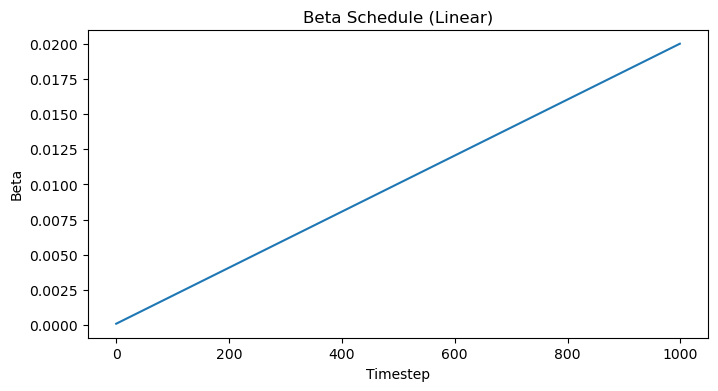

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


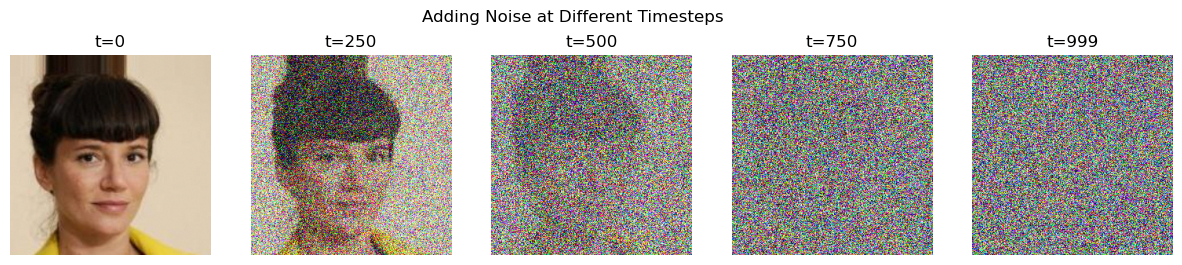

In [8]:
# Visualize the beta schedule
betas, alphas_cumprod= get_beta_schedule(1000)
plt.figure(figsize=(8, 4))
plt.plot(betas.cpu().numpy())
plt.title("Beta Schedule (Linear)")
plt.xlabel("Timestep")
plt.ylabel("Beta")
plt.show()

# Visualize how noise is added to a sample image
idx = 0  # Pick the first image in sample_images
T = 1000  # Total timesteps
sample_images = next(iter(train_loader))[0]  # Get a batch of images
x0 = sample_images[idx].unsqueeze(0).to(device)
timesteps = [0, T//4, T//2, 3*T//4, T-1]
plt.figure(figsize=(15, 3))
for i, t_step in enumerate(timesteps):
    t_tensor = torch.full((1,), t_step, device=device, dtype=torch.long)
    noise = torch.randn_like(x0)
    x_t = add_noise(x0, noise, t_tensor, alphas_cumprod)
    img = (x_t[0].cpu().numpy() + 1) / 2  # Denormalize
    plt.subplot(1, len(timesteps), i+1)
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.axis('off')
    plt.title(f"t={t_step}")
plt.suptitle("Adding Noise at Different Timesteps")
plt.show()

In [11]:
@torch.no_grad()
def sample_from_diffusion(model, vae_decoder, betas, alphas_cumprod, T, num_samples, latent_shape, device):
    x_t = torch.randn(num_samples, *latent_shape, device=device)
    
    # Loop through timesteps in reverse order for sampling
    for t in tqdm(reversed(range(T)), desc="Sampling", total=T):
        t_tensor = torch.full((num_samples,), t, device=device, dtype=torch.long)
        
        # Predict noise for the current timestep
        predicted_noise = model(x_t, t_tensor)
        
        # Get pre-calculated schedule values for the current timestep t
        beta_t = betas[t]
        alpha_t = 1.0 - beta_t
        alpha_bar_t = alphas_cumprod[t]
        
        # Use the predicted noise to calculate the mean of the reverse distribution
        # This is the core DDPM reverse process equation
        mean = (1 / torch.sqrt(alpha_t)) * (x_t - (beta_t / torch.sqrt(1. - alpha_bar_t)) * predicted_noise)
        
        if t > 0:
            # For any step other than the last one, add noise
            noise = torch.randn_like(x_t)
            # The variance of the reverse process is fixed to beta_t
            x_t = mean + torch.sqrt(beta_t) * noise
        else:
            x_t = mean
    images = vae_decoder(x_t)
    return images

def show_images(images, title="Generated Images"):
    # print(images)
    images = images.clamp(-1, 1)  # Ensure images are in [-1, 1] range
    images = (images.cpu().numpy() + 1) / 2 # Denormalize to [0, 1]
    plt.figure(figsize=(8, 8))
    for i in range(min(images.shape[0], 16)):
        plt.subplot(4, 4, i + 1)
        # For RGB images, imshow needs (H, W, C) format
        if images.shape[1] == 3: # Check if it's an RGB image
            plt.imshow(np.transpose(images[i], (1, 2, 0)))
        else: # Grayscale
            plt.imshow(images[i].squeeze(), cmap='gray')
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

### 2.5 Training the Latent Diffusion Model


Training Latent Diffusion Model...


Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling: 100%|██████████| 1000/1000 [01:17<00:00, 12.92it/s]


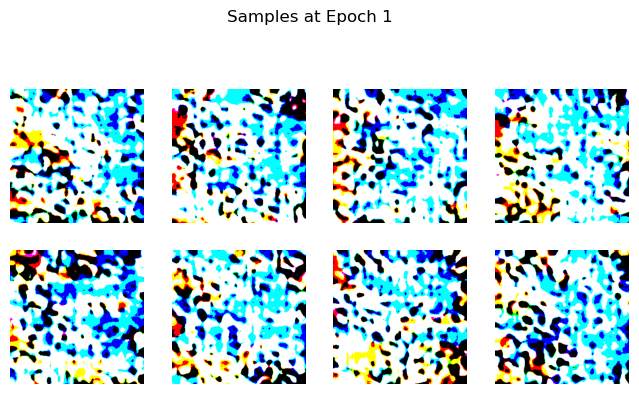

LDM Epoch 1/25: 100%|██████████| 2544/2544 [01:52<00:00, 22.60it/s]


LDM Epoch 1/25, Loss: 0.1929


Sampling: 100%|██████████| 1000/1000 [00:01<00:00, 828.35it/s]


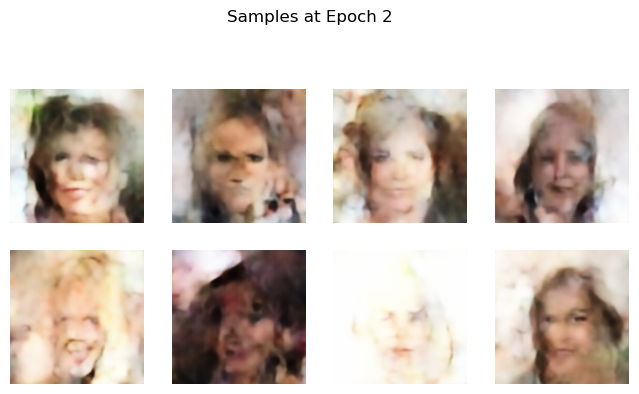

LDM Epoch 2/25: 100%|██████████| 2544/2544 [01:52<00:00, 22.71it/s]


LDM Epoch 2/25, Loss: 0.1553


Sampling: 100%|██████████| 1000/1000 [00:01<00:00, 829.94it/s]


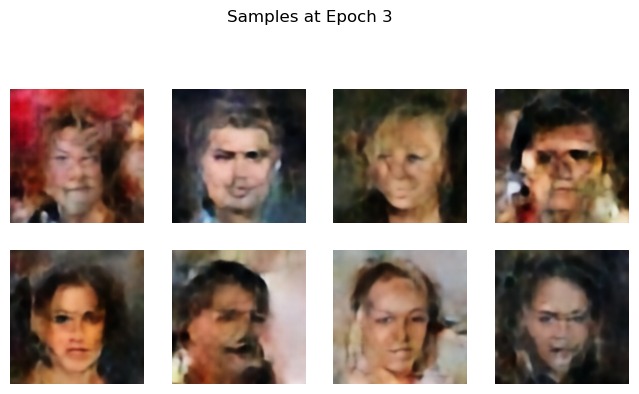

LDM Epoch 3/25: 100%|██████████| 2544/2544 [01:53<00:00, 22.47it/s]


LDM Epoch 3/25, Loss: 0.1491


Sampling: 100%|██████████| 1000/1000 [00:01<00:00, 827.96it/s]


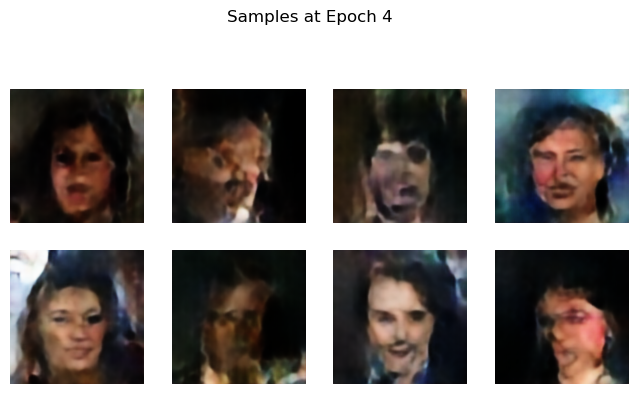

LDM Epoch 4/25: 100%|██████████| 2544/2544 [01:52<00:00, 22.53it/s]


LDM Epoch 4/25, Loss: 0.1449


Sampling: 100%|██████████| 1000/1000 [00:01<00:00, 818.18it/s]


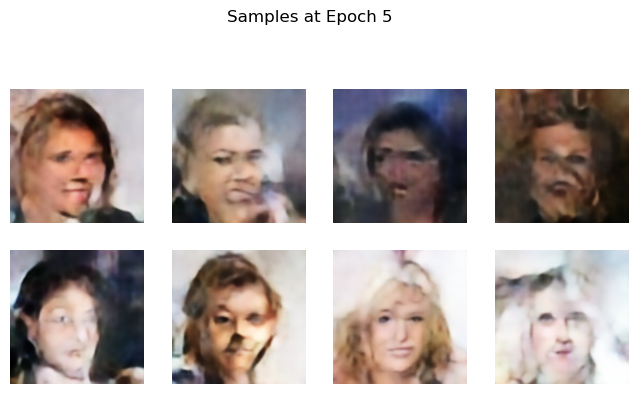

LDM Epoch 5/25: 100%|██████████| 2544/2544 [01:53<00:00, 22.41it/s]


LDM Epoch 5/25, Loss: 0.1430


Sampling: 100%|██████████| 1000/1000 [00:01<00:00, 825.46it/s]


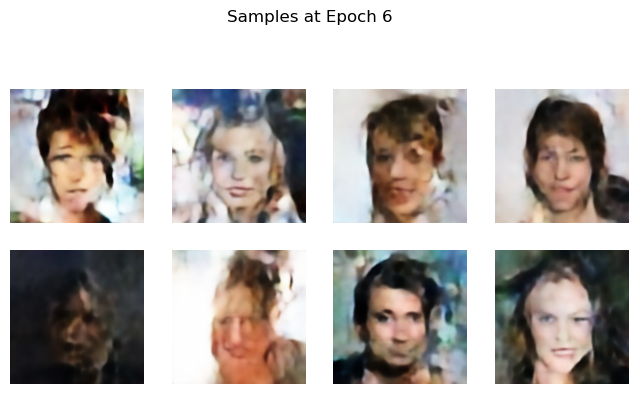

LDM Epoch 6/25: 100%|██████████| 2544/2544 [01:52<00:00, 22.59it/s]


LDM Epoch 6/25, Loss: 0.1415


Sampling: 100%|██████████| 1000/1000 [00:01<00:00, 638.11it/s]


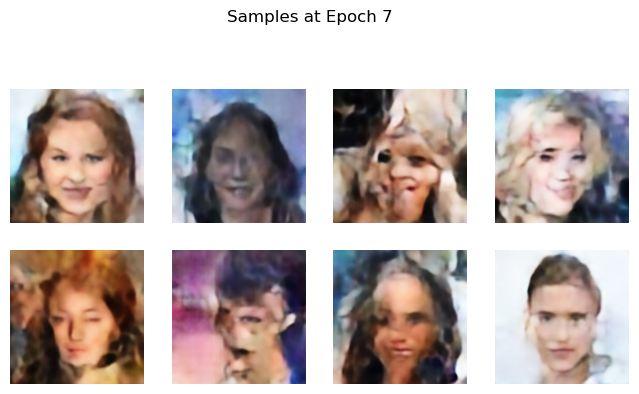

LDM Epoch 7/25: 100%|██████████| 2544/2544 [01:50<00:00, 22.95it/s]


LDM Epoch 7/25, Loss: 0.1395


Sampling: 100%|██████████| 1000/1000 [00:01<00:00, 834.36it/s]


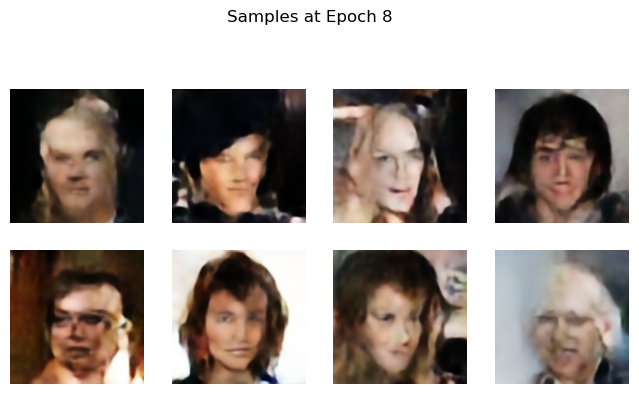

LDM Epoch 8/25: 100%|██████████| 2544/2544 [01:52<00:00, 22.59it/s]


LDM Epoch 8/25, Loss: 0.1390


Sampling: 100%|██████████| 1000/1000 [00:01<00:00, 833.19it/s]


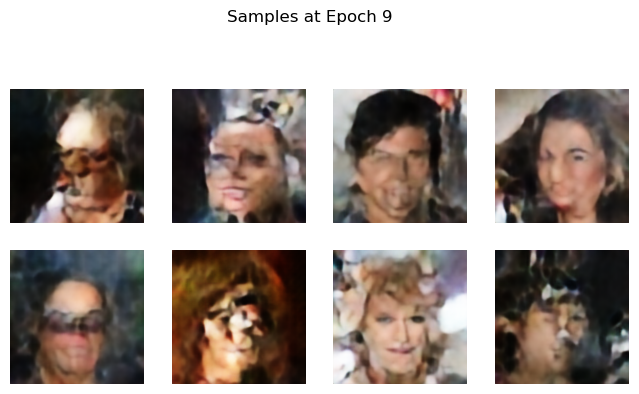

LDM Epoch 9/25: 100%|██████████| 2544/2544 [01:53<00:00, 22.48it/s]


LDM Epoch 9/25, Loss: 0.1378


Sampling: 100%|██████████| 1000/1000 [00:01<00:00, 829.22it/s]


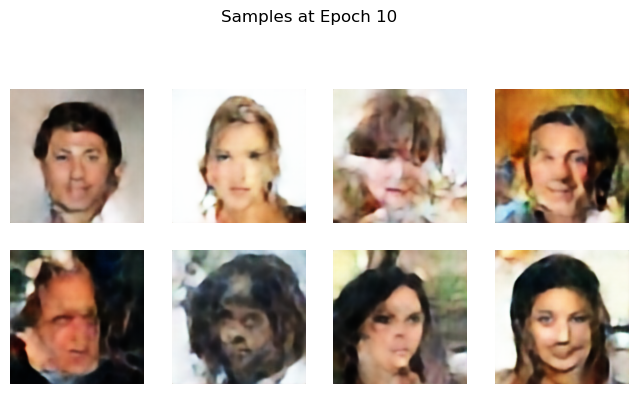

LDM Epoch 10/25: 100%|██████████| 2544/2544 [01:52<00:00, 22.54it/s]


LDM Epoch 10/25, Loss: 0.1373


Sampling: 100%|██████████| 1000/1000 [00:01<00:00, 823.96it/s]


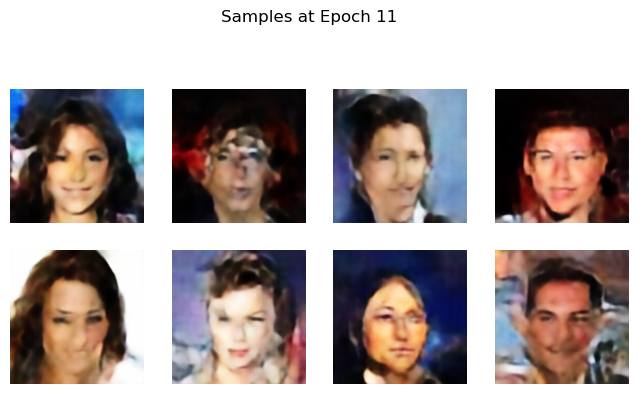

LDM Epoch 11/25: 100%|██████████| 2544/2544 [01:52<00:00, 22.59it/s]


LDM Epoch 11/25, Loss: 0.1372


Sampling: 100%|██████████| 1000/1000 [00:01<00:00, 831.53it/s]


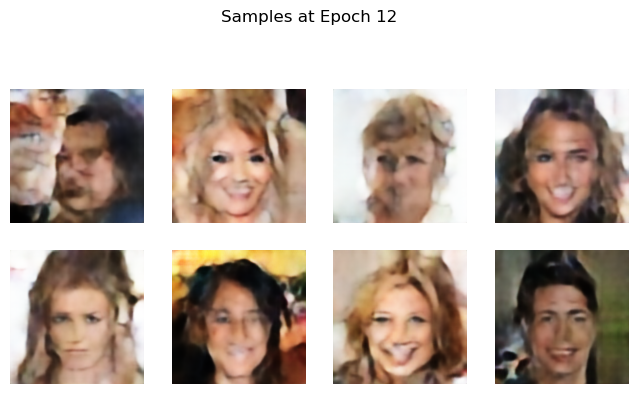

LDM Epoch 12/25: 100%|██████████| 2544/2544 [01:52<00:00, 22.60it/s]


LDM Epoch 12/25, Loss: 0.1366


Sampling: 100%|██████████| 1000/1000 [00:01<00:00, 831.13it/s]


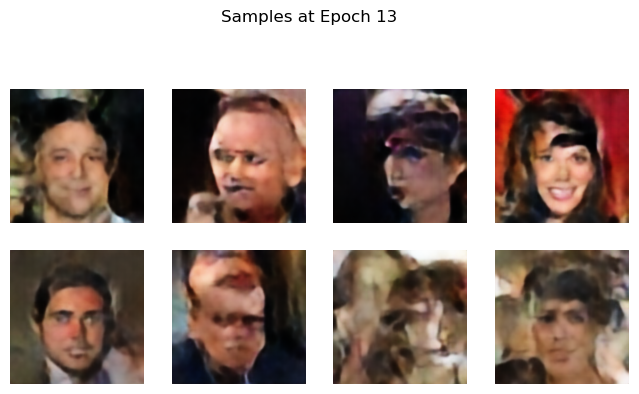

LDM Epoch 13/25: 100%|██████████| 2544/2544 [01:53<00:00, 22.48it/s]


LDM Epoch 13/25, Loss: 0.1364


Sampling: 100%|██████████| 1000/1000 [00:01<00:00, 799.42it/s]


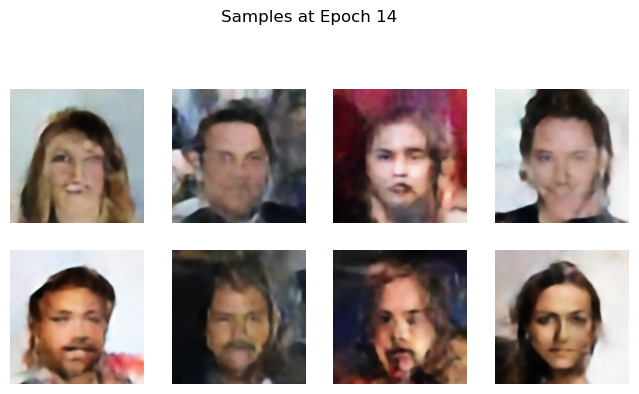

LDM Epoch 14/25: 100%|██████████| 2544/2544 [01:51<00:00, 22.83it/s]


LDM Epoch 14/25, Loss: 0.1357


Sampling: 100%|██████████| 1000/1000 [00:01<00:00, 838.06it/s]


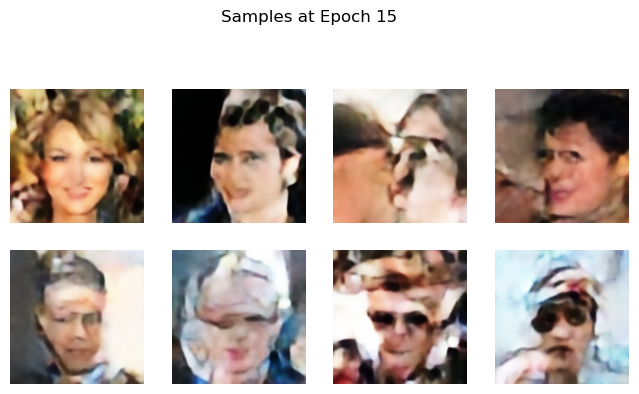

LDM Epoch 15/25: 100%|██████████| 2544/2544 [01:52<00:00, 22.60it/s]


LDM Epoch 15/25, Loss: 0.1345


Sampling: 100%|██████████| 1000/1000 [00:01<00:00, 811.67it/s]


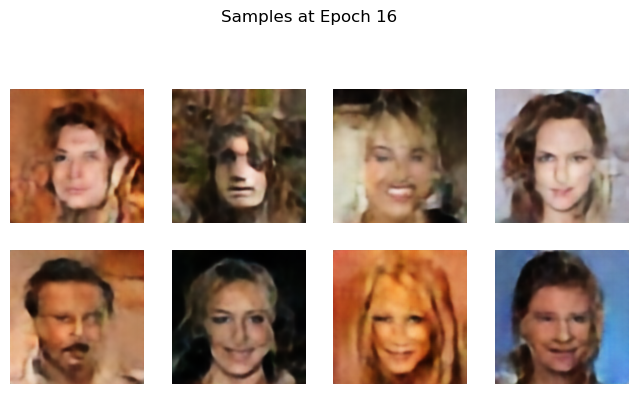

LDM Epoch 16/25: 100%|██████████| 2544/2544 [01:54<00:00, 22.30it/s]


LDM Epoch 16/25, Loss: 0.1336


Sampling: 100%|██████████| 1000/1000 [00:01<00:00, 826.96it/s]


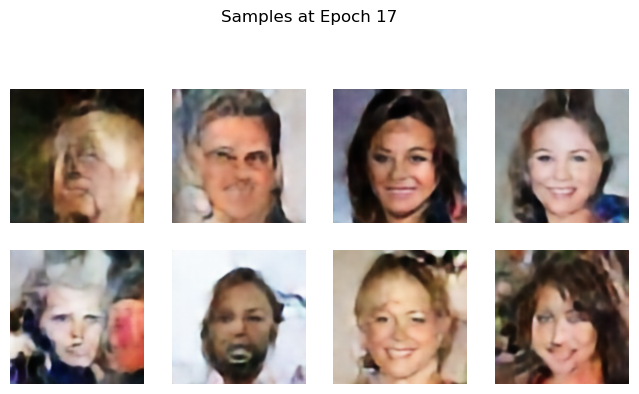

LDM Epoch 17/25: 100%|██████████| 2544/2544 [01:54<00:00, 22.29it/s]


LDM Epoch 17/25, Loss: 0.1338


Sampling: 100%|██████████| 1000/1000 [00:01<00:00, 834.50it/s]


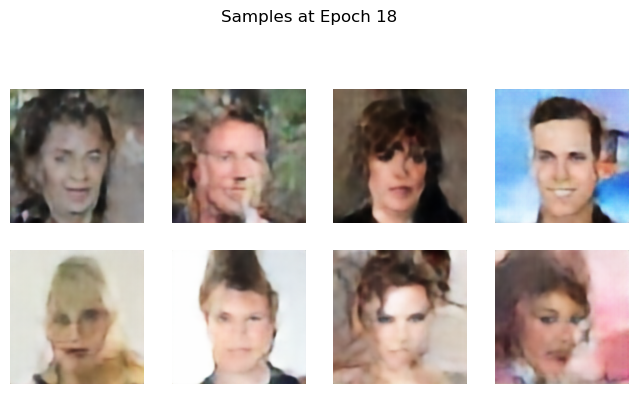

LDM Epoch 18/25: 100%|██████████| 2544/2544 [01:54<00:00, 22.23it/s]


LDM Epoch 18/25, Loss: 0.1340


Sampling: 100%|██████████| 1000/1000 [00:01<00:00, 823.92it/s]


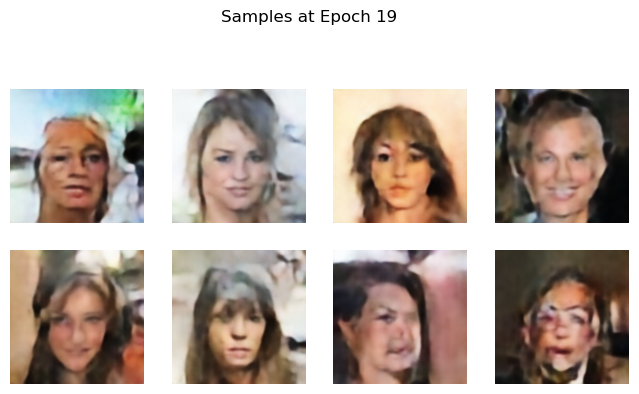

LDM Epoch 19/25: 100%|██████████| 2544/2544 [01:54<00:00, 22.29it/s]


LDM Epoch 19/25, Loss: 0.1330


Sampling: 100%|██████████| 1000/1000 [00:01<00:00, 822.41it/s]


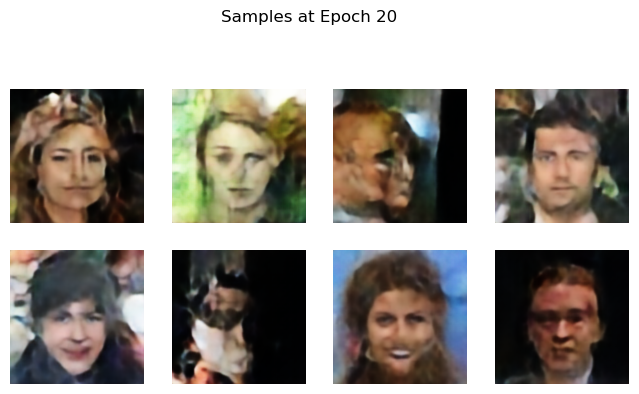

LDM Epoch 20/25: 100%|██████████| 2544/2544 [01:54<00:00, 22.29it/s]


LDM Epoch 20/25, Loss: 0.1331


Sampling: 100%|██████████| 1000/1000 [00:01<00:00, 828.77it/s]


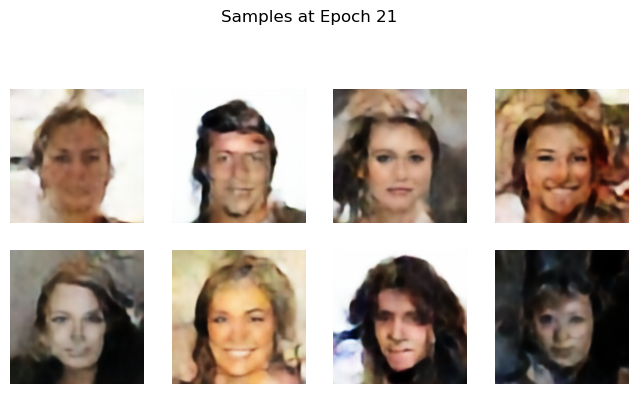

LDM Epoch 21/25: 100%|██████████| 2544/2544 [01:53<00:00, 22.35it/s]


LDM Epoch 21/25, Loss: 0.1330


Sampling: 100%|██████████| 1000/1000 [00:01<00:00, 658.04it/s]


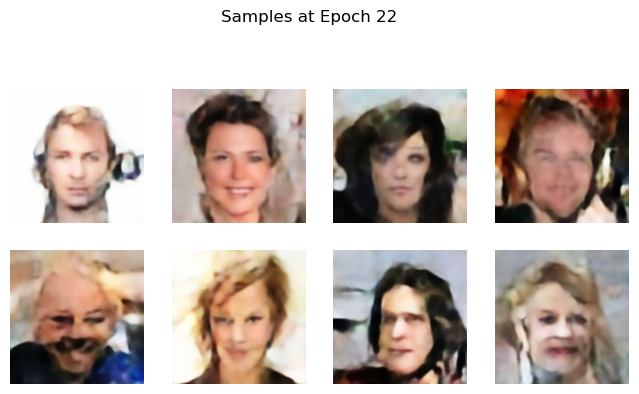

LDM Epoch 22/25: 100%|██████████| 2544/2544 [01:52<00:00, 22.60it/s]


LDM Epoch 22/25, Loss: 0.1331


Sampling: 100%|██████████| 1000/1000 [00:01<00:00, 833.80it/s]


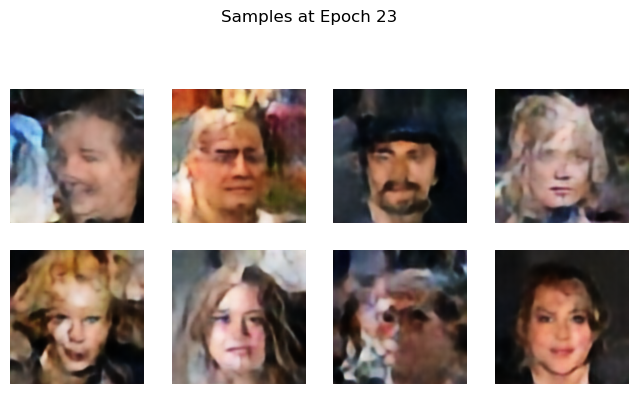

LDM Epoch 23/25: 100%|██████████| 2544/2544 [01:52<00:00, 22.52it/s]


LDM Epoch 23/25, Loss: 0.1329


Sampling: 100%|██████████| 1000/1000 [00:01<00:00, 838.11it/s]


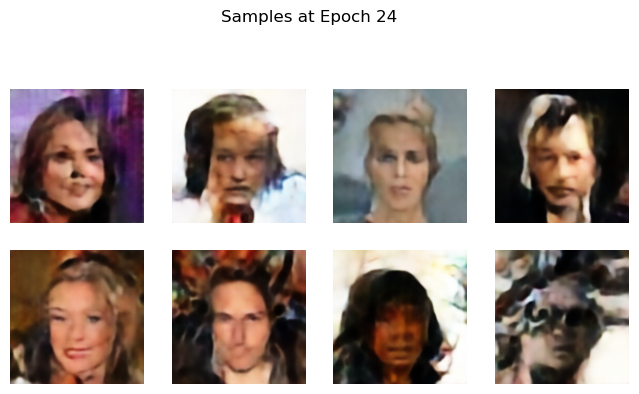

LDM Epoch 24/25: 100%|██████████| 2544/2544 [01:52<00:00, 22.54it/s]


LDM Epoch 24/25, Loss: 0.1321


Sampling: 100%|██████████| 1000/1000 [00:01<00:00, 821.25it/s]


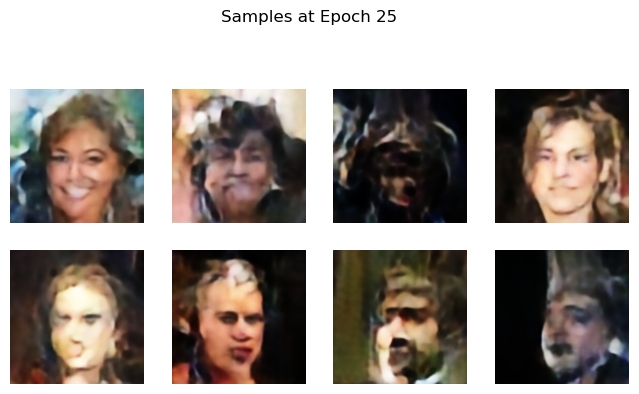

LDM Epoch 25/25: 100%|██████████| 2544/2544 [01:52<00:00, 22.52it/s]

LDM Epoch 25/25, Loss: 0.1314


In [10]:
device = 'cuda'
# The UNet now expects latent_channels as input
ldm_unet = UNet(in_channels=latent_channels, base_channels=64, time_emb_dim=256).to(device)
ldm_optimizer = torch.optim.Adam(ldm_unet.parameters(), lr=1e-4)

T = 1000 # Total diffusion steps
betas, alphas_cumprod = get_beta_schedule(T)

ldm_epochs = 25 # LDM training can also be long, reduced for demo

print("\nTraining Latent Diffusion Model...")
for epoch in range(ldm_epochs):
    ldm_unet.train()
    total_loss = 0
    with torch.no_grad():
        num_samples = 8
        latent_spatial_dim = img_size // (2**4)
        latent_shape = (latent_channels, latent_spatial_dim, latent_spatial_dim)
        samples = sample_from_diffusion(ldm_unet, vae_spatial.decoder, betas, alphas_cumprod, T, num_samples, latent_shape, device)
        show_images(samples, title=f"Samples at Epoch {epoch+1}")
    for batch_idx, (images, _) in enumerate(tqdm(train_loader, desc=f"LDM Epoch {epoch+1}/{ldm_epochs}")):
        images = images.to(device)
        
        with torch.no_grad(): # Encode images to latent space, no gradients needed for VAE here
            _, latents_0 = vae_spatial(images)
        
        # Sample a random timestep
        t = torch.randint(0, T, (latents_0.shape[0],), device=device).long()
        
        # Generate random noise
        noise = torch.randn_like(latents_0).to(device)

        
        # Add noise to latents_0 to get noisy latents_t
        latents_t = add_noise(latents_0.to(device), noise, t, alphas_cumprod).to(device    )
        
        ldm_optimizer.zero_grad()
        
        # Predict the noise using the U-Net
        predicted_noise = ldm_unet(latents_t, t)
        # Calculate loss
        loss = F.mse_loss(predicted_noise, noise)
        
        loss.backward()
        ldm_optimizer.step()
        total_loss += loss.item()
    ldm_unet.eval()
        
    print(f"LDM Epoch {epoch+1}/{ldm_epochs}, Loss: {total_loss / len(train_loader):.4f}")

## Conclusion
This notebook introduced the theoretical concepts behind DDPMs, LDMs, and Stable Diffusion, highlighting the evolution from pixel-space diffusion to latent-space and conditional generation. The provided coding demo illustrates a simplified Latent Diffusion Model training pipeline, demonstrating how higher-resolution images from the CelebA dataset can be generated by denoising in a learned latent space.